<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbers from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

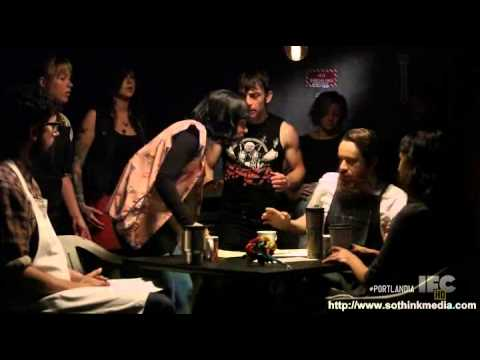

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'C:\\Users\\Lenovo\\DS-Unit-4-Sprint-1-NLP\\module1-text-data'

In [ ]:
"""
Import Statements
"""

# Base
from collections import Counter
import re
 
import pandas as pd

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

nlp = spacy.load("en_core_web_lg")

In [11]:
# checking initial dataset looking at the first 10 rows

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head(10)

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating
5,The Factory - Cafe With a Soul,11/20/2016 1 check-in Very cute cafe! I think...,4.0 star rating
6,The Factory - Cafe With a Soul,"10/27/2016 2 check-ins Listed in ""Nuptial Cof...",4.0 star rating
7,The Factory - Cafe With a Soul,11/2/2016 2 check-ins Love this place! 5 sta...,5.0 star rating
8,The Factory - Cafe With a Soul,"10/25/2016 1 check-in Ok, let's try this appr...",3.0 star rating
9,The Factory - Cafe With a Soul,11/10/2016 3 check-ins This place has been sh...,5.0 star rating


## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

## Using two samples to try Pure Python tokenizing for full_review_text and star_rating columns 

In [43]:
sample_text = "11/2/2016 Great service, Good food and drinks!"

In [55]:
sample_rating = "5.0 star rating"

In [45]:
# tokenize using regular expressions removing numbers and special characters and transforming all letters into lowercase
# check sample_text example
def tokenize(text):
    """Parses a string into a list os semantic units(words)
    Args:
        text (str): The string that the function will tokenize
    Returns:
        list: tokens parsed out by the mechanics of your choice
    """
    
    tokens = re.sub(r'[^a-zA-Z]', ' ', text)
    tokens = tokens.lower().split()
    
    return tokens

In [59]:
# tokenize rating using regular expressions, leaving only the numbers for rating
# check sample_rating example
def tokenize_rating(text):
    """Parses a string into a list os semantic units(words)
    Args:
        text (str): The string that the function will tokenize
    Returns:
        list: tokens parsed out by the mechanics of your choice
    """
    
    tokens_rating = re.sub(r'[^1-5]', '', text)
    
    return tokens_rating

In [46]:
tokenize(sample_text)

['great', 'service', 'good', 'food', 'and', 'drinks']

In [60]:
tokenize_rating(sample_rating)

'5'

## applying pure python tokenize to the full_review_text and creating a new column called tokens

In [51]:
shops['tokens'] = shops['full_review_text'].apply(tokenize)

In [52]:
shops['tokens'].head()

0    [check, in, love, love, loved, the, atmosphere...
1    [listed, in, date, night, austin, ambiance, in...
2    [check, in, listed, in, brunch, spots, i, love...
3    [very, cool, decor, good, drinks, nice, seatin...
4    [check, in, they, are, located, within, the, n...
Name: tokens, dtype: object

## applying pure python tokenize to the star_rating and creating a new column called tokens_rating

In [61]:
shops['tokens_rating'] = shops['star_rating'].apply(tokenize_rating)

In [62]:
shops['tokens_rating'].head()

0    5
1    4
2    4
3    2
4    4
Name: tokens_rating, dtype: object

In [63]:
# new df with tokens
shops.head()

,coffee_shop_name,full_review_text,star_rating,tokens,tokens_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,"[check, in, love, love, loved, the, atmosphere...",5
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,"[listed, in, date, night, austin, ambiance, in...",4
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating,"[check, in, listed, in, brunch, spots, i, love...",4
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating,"[very, cool, decor, good, drinks, nice, seatin...",2
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating,"[check, in, they, are, located, within, the, n...",4


## transforming tokens_rating into int type

In [64]:
# checking dtypes
shops.dtypes

coffee_shop_name    object
full_review_text    object
star_rating         object
tokens              object
tokens_rating       object
dtype: object

In [71]:
shops['tokens_rating'] = shops['tokens_rating'].astype(str).astype(int)

In [72]:
shops.dtypes

coffee_shop_name    object
full_review_text    object
star_rating         object
tokens              object
tokens_rating        int32
dtype: object

## using spacy tokenizer

In [77]:
nlp = spacy.load("en_core_web_lg")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [84]:
tokens = []

""" Update tokens w/o stopwords and punctuation"""
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

shops['tokens'] = tokens

In [85]:
shops['tokens'].head()

0    [ , 11/25/2016, 1, check-in, love, love, loved...
1    [ , 12/2/2016, listed, date, night:, austin,, ...
2    [ , 11/30/2016, 1, check-in, listed, brunch, s...
3    [ , 11/25/2016, cool, decor!, good, drinks, ni...
4    [ , 12/3/2016, 1, check-in, located, northcros...
Name: tokens, dtype: object

## defining count function to define the number of words in the text

In [229]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

## defining my stop words list

In [226]:
STOP_WORDS = nlp.Defaults.stop_words.union(["check-in", " ", "it's", "1", "-", "i'm", "i've", "place", "coffee", "got", "austin", "ordered"])

## using my new stop words list to update tokens excluding common words with none or less value

In [227]:
tokens = []

""" Update tokens w/o defined stopwords and punctuation"""
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

shops['tokens'] = tokens

## count of words for all shop reviews

In [230]:
wc = count(shops['tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
125,great,2438,3250,1.0,0.008664,0.008664,0.320116
166,like,2034,2902,2.0,0.007736,0.016400,0.267069
170,good,2084,2779,3.0,0.007408,0.023809,0.273634
36,love,1434,1806,4.0,0.004815,0.028623,0.188288
799,little,1230,1479,5.0,0.003943,0.032566,0.161502


In [166]:
from collections import Counter

# instantiating an empty object 
word_counts = Counter()

# Update it based on a split of each of our documents
shops['tokens'].apply(lambda x: word_counts.update(x))

# top 10 most common words
word_counts.most_common(10)

[('great', 3250),
 ('like', 2902),
 ('good', 2779),
 ('love', 1806),
 ('little', 1479),
 ("don't", 1395),
 ('nice', 1368),
 ('food', 1363),
 ('time', 1345),
 ('pretty', 1339)]

## defining top 10 words most commonly used

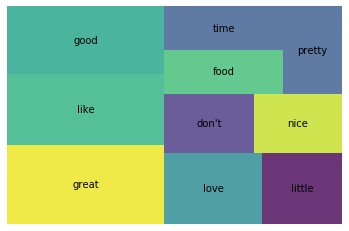

In [167]:
wc_top10 = wc[wc['rank'] <= 10]

squarify.plot(sizes=wc_top10['pct_total'], label=wc_top10['word'], alpha=.8 )
plt.axis('off')
plt.show()

## defining worst and best shops

In [168]:
worst_shops = shops[shops['tokens_rating'] <= 3]
best_shops = shops[shops['tokens_rating'] >= 4]

## counting words for worst shops 

In [169]:
tokens_worst_shops = []

""" Update tokens w/o defined stopwords and punctuation"""
for doc in tokenizer.pipe(worst_shops['full_review_text'], batch_size=500):
    
    doc_tokens_worst_shops = []
    
    for token in doc:
        if token.text.lower() not in STOP_WORDS:
            doc_tokens_worst_shops.append(token.text.lower())

    tokens_worst_shops.append(doc_tokens_worst_shops)

worst_shops['tokens_worst_shops'] = tokens_worst_shops

C:\Users\Lenovo\Anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [170]:
wc_worst_shops = count(worst_shops['tokens_worst_shops'])
wc_worst_shops.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
12,like,548,834,1.0,0.010023,0.010023,0.371274
16,good,441,599,2.0,0.007199,0.017222,0.298780
188,don't,340,430,3.0,0.005168,0.022390,0.230352
88,food,266,369,4.0,0.004435,0.026824,0.180217
239,time,264,351,5.0,0.004218,0.031043,0.178862


## defining top 10 words most commonly used for worst_shops

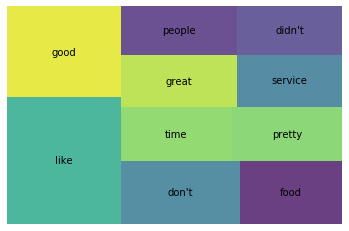

In [171]:
wc_worst_shops_top10 = wc_worst_shops[wc_worst_shops['rank'] <= 10]

squarify.plot(sizes=wc_worst_shops_top10['pct_total'], label=wc_worst_shops_top10['word'], alpha=.8 )
plt.axis('off')
plt.show()

## counting words for best shops

In [172]:
tokens_best_shops = []

""" Update tokens w/o defined stopwords and punctuation"""
for doc in tokenizer.pipe(best_shops['full_review_text'], batch_size=500):
    
    doc_tokens_best_shops = []
    
    for token in doc:
        if token.text.lower() not in STOP_WORDS:
            doc_tokens_best_shops.append(token.text.lower())

    tokens_best_shops.append(doc_tokens_best_shops)

best_shops['tokens_best_shops'] = tokens_best_shops

C:\Users\Lenovo\Anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [173]:
wc_best_shops = count(best_shops['tokens_best_shops'])
wc_best_shops.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
125,great,2174,2902,1.0,0.009942,0.009942,0.354072
314,good,1643,2180,2.0,0.007468,0.017410,0.267590
216,like,1486,2068,3.0,0.007084,0.024494,0.242020
36,love,1263,1604,4.0,0.005495,0.029989,0.205700
609,little,1027,1230,5.0,0.004214,0.034203,0.167264


## defining top 10 words most commonly used for best_shops

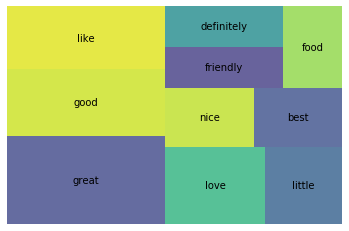

In [174]:
wc_best_shops_top10 = wc_best_shops[wc_best_shops['rank'] <= 10]

squarify.plot(sizes=wc_best_shops_top10['pct_total'], label=wc_best_shops_top10['word'], alpha=.8 )
plt.axis('off')
plt.show()

## counting number of 5,4,3,2,1 start ratings

In [175]:
shops['tokens_rating'].value_counts()

5    3780
4    2360
3     738
2     460
1     278
Name: tokens_rating, dtype: int64

## Cumulative Distribution Plot

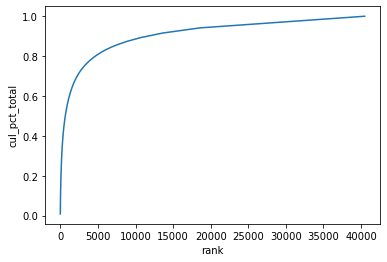

In [176]:
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

## tail of review countings

In [177]:
wc.tail(20)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
40456,delicious...and,1,1,40459.0,0.000003,0.999949,0.000131
40463,"(turkey,",1,1,40460.0,0.000003,0.999952,0.000131
40461,romaine,1,1,40461.0,0.000003,0.999955,0.000131
40460,"rib,",1,1,40462.0,0.000003,0.999957,0.000131
40462,"predictably,",1,1,40463.0,0.000003,0.999960,0.000131
40464,blts,1,1,40464.0,0.000003,0.999963,0.000131
40459,(+,1,1,40465.0,0.000003,0.999965,0.000131
40458,turkey),1,1,40466.0,0.000003,0.999968,0.000131
40465,(pork),1,1,40467.0,0.000003,0.999971,0.000131
40466,roomier,1,1,40468.0,0.000003,0.999973,0.000131


In [178]:
wc['appears_in_pct'].describe()

count    40478.000000
mean         0.001117
std          0.005882
min          0.000131
25%          0.000131
50%          0.000131
75%          0.000525
max          0.320116
Name: appears_in_pct, dtype: float64

## excluding the extremes

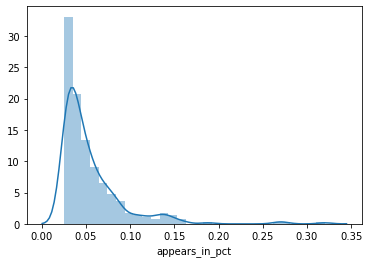

In [179]:
# Tree-Map w/ Words that appear in a least 2.5% of documents. 

wc = wc[wc['appears_in_pct'] >= 0.025]

sns.distplot(wc['appears_in_pct']);

## applying lemma in a sample_text

In [189]:
sample_text = "11/2/2016 Great service, Good food and drinks!"

# Instantiate base model
nlp = spacy.load("en_core_web_lg")

doc = nlp(sample_text)

# Lemma Attributes
for token in doc:
    print(token.text, "  ", token.lemma_)

11/2/2016    11/2/2016
Great    great
service    service
,    ,
Good    good
food    food
and    and
drinks    drink
!    !


## defining lemma function

In [214]:
# Lemmas functions
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= '-PRON-') and (token.is_space == False)and (token.is_digit == False):
            lemmas.append(token.lemma_)
    
    return lemmas

In [215]:
shops['lemmas'] = shops['full_review_text'].apply(get_lemmas)

In [216]:
shops['lemmas'].head()

0    [11/25/2016, check, Love, love, love, atmosphe...
1    [12/2/2016, list, Date, Night, Austin, Ambianc...
2    [11/30/2016, check, list, Brunch, Spots, love,...
3    [11/25/2016, cool, decor, good, drink, nice, s...
4    [12/3/2016, check, locate, Northcross, mall, s...
Name: lemmas, dtype: object

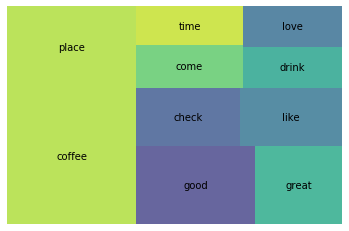

In [217]:
wc = count(shops['lemmas'])
wc_top10 = wc[wc['rank'] <= 10]

squarify.plot(sizes=wc_top10['pct_total'], label=wc_top10['word'], alpha=.8 )
plt.axis('off')
plt.show()

## shop reviews by rating

In [197]:
s1 = shops[shops['tokens_rating'] == 1]
s2 = shops[shops['tokens_rating'] == 2]
s3 = shops[shops['tokens_rating'] == 3]
s4 = shops[shops['tokens_rating'] == 4]
s5 = shops[shops['tokens_rating'] == 5]

## defining top 10 words most commonly used for shops star_rating 1

In [231]:
s1['lemmas'] = s1['full_review_text'].apply(get_lemmas)

C:\Users\Lenovo\Anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


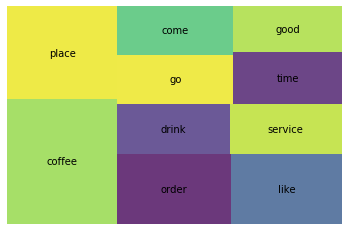

In [232]:
wc_s1 = count(s1['lemmas'])
wc_s1_top10 = wc_s1[wc_s1['rank'] <= 10]

squarify.plot(sizes=wc_s1_top10['pct_total'], label=wc_s1_top10['word'], alpha=.8 )
plt.axis('off')
plt.show()

## defining top 10 words most commonly used for shops star_rating 2

In [233]:
s2['lemmas'] = s2['full_review_text'].apply(get_lemmas)

C:\Users\Lenovo\Anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


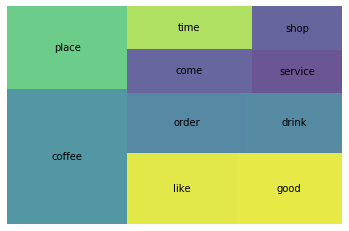

In [234]:
wc_s2 = count(s2['lemmas'])
wc_s2_top10 = wc_s2[wc_s2['rank'] <= 10]

squarify.plot(sizes=wc_s2_top10['pct_total'], label=wc_s2_top10['word'], alpha=.8 )
plt.axis('off')
plt.show()

## defining top 10 words most commonly used for shops star_rating 3

In [235]:
s3['lemmas'] = s3['full_review_text'].apply(get_lemmas)

C:\Users\Lenovo\Anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


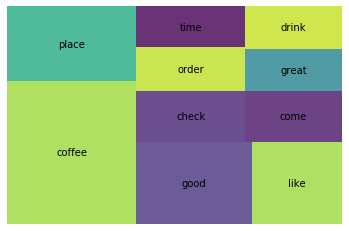

In [236]:
wc_s3 = count(s3['lemmas'])
wc_s3_top10 = wc_s3[wc_s3['rank'] <= 10]

squarify.plot(sizes=wc_s3_top10['pct_total'], label=wc_s3_top10['word'], alpha=.8 )
plt.axis('off')
plt.show()

## defining top 10 words most commonly used for shops star_rating 4

In [237]:
s4['lemmas'] = s4['full_review_text'].apply(get_lemmas)

C:\Users\Lenovo\Anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


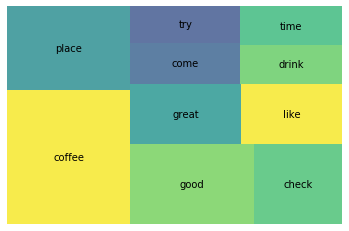

In [238]:
wc_s4 = count(s4['lemmas'])
wc_s4_top10 = wc_s4[wc_s4['rank'] <= 10]

squarify.plot(sizes=wc_s4_top10['pct_total'], label=wc_s4_top10['word'], alpha=.8 )
plt.axis('off')
plt.show()

## defining top 10 words most commonly used for shops star_rating 5

In [239]:
s5['lemmas'] = s5['full_review_text'].apply(get_lemmas)

C:\Users\Lenovo\Anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


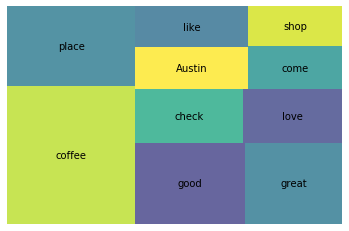

In [240]:
wc_s5 = count(s5['lemmas'])
wc_s5_top10 = wc_s5[wc_s5['rank'] <= 10]

squarify.plot(sizes=wc_s5_top10['pct_total'], label=wc_s5_top10['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


## Bad reviews uses words such as didn't, don't, service, people, time
## Good reviews uses words such as great, friendly, definitely, love, best

### From this I get the message of things not done, available, something negative byt the number of times words as didn't and don't were used. Time, people and service was referred possibily in a bad conotation too.
### About the best shops, verbs as love show is really good, words such as great, friendly, definitely, best are firmly positive and transmit that connotation too.

In [213]:
dir(token)

['_',
 '__bytes__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 'ancestors',
 'check_flag',
 'children',
 'cluster',
 'conjuncts',
 'dep',
 'dep_',
 'doc',
 'ent_id',
 'ent_id_',
 'ent_iob',
 'ent_iob_',
 'ent_kb_id',
 'ent_kb_id_',
 'ent_type',
 'ent_type_',
 'get_extension',
 'has_extension',
 'has_vector',
 'head',
 'i',
 'idx',
 'is_alpha',
 'is_ancestor',
 'is_ascii',
 'is_bracket',
 'is_currency',
 'is_digit',
 'is_left_punct',
 'is_lower',
 'is_oov',
 'is_punct',
 'is_quote',
 'is_right_punct',
 'is_sent_start',
 'is_space',
 'is_stop',
 'is_title',
 'is_upper',
 'lang',
 'lang_',
 'left_edge',
 'lefts',
 'lemma',
 'lemma_',
 'lex_id',
 'like_email',
 'li

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 



In [247]:
sentence = nlp(u'Latest Rumours: Manchester United is looking to sign Harry Kane for $90 million')

In [ ]:
doc = nlp("Mr. Best flew to New York on Saturday morning.")

In [ ]:
doc1 = nlp("A phrase with another phrase occurs.")

In [259]:
indeed = nlp("""Triplebyte helps companies find and hire great technical talent. 
For any company building software, this is crucial for success. 
A recent survey of top C-Level Executives, across multiple industries, 
showed that software, R&D and recruiting technical talent are the top areas 
they are planning increased investment and budget over the next 5 years. 
Companies like Apple, 
Dropbox and American Express trust Triplebyte’s online technical assessment 
to identify the best engineers for their open roles and reduce the time and effort 
it takes to hire them.
Earlier this year we raised a $35 million Series B and our team of 
40 will double in size during 2019. 
Now is a great time to join as we're on an exciting growth trajectory. 
You will have lots of opportunity for taking on responsibility and 
developing new skills quickly.
We have built Machine Learning models that predict the likelihood of an engineer 
getting an offer from a particular company. 
Interviewing and assessing engineering talent tends to be noisy, 
but our technical assessment has proven to be good enough to extract meaningful signals. 
We collect data on interview results and in-house evaluations, 
which gives us a unique dataset to play with. 
We've used that data to deliver a 40% conversion rate on our candidates 
at interview to offer, compared to the industry standard 20%.
Our mission is to create a scientific method for identifying great talent and intelligently 
route it to the best place, streamlining and speeding up the recruitment process, 
while removing human biases that can hold back some candidates.We're an experienced team, 
the founders have each built and sold companies before. 
Ammon and Guillaume founded Socialcam (acquired by Autodesk for $60 million) 
and Harj was the first partner hired at Y Combinator since its founding.""")

## playing with entities

In [249]:
for word in sentence:
    print(word.text)

Latest
Rumours
:
Manchester
United
is
looking
to
sign
Harry
Kane
for
$
90
million


In [250]:
for entity in sentence.ents:
    print(entity.text + ' - ' + entity.label_ + ' - ' + str(spacy.explain(entity.label_)))

Manchester United - ORG - Companies, agencies, institutions, etc.
Harry Kane - PERSON - People, including fictional
$90 million - MONEY - Monetary values, including unit


In [257]:
ents = list(doc.ents)
ents
# assert ents[0].label == 346
# assert ents[0].label_ == "PERSON"
# assert ents[0].text == "Mr. Best"

[Best, New York, Saturday, morning]

In [258]:
for entity in doc.ents:
    print(entity.text + ' - ' + entity.label_ + ' - ' + str(spacy.explain(entity.label_)))

Best - PERSON - People, including fictional
New York - GPE - Countries, cities, states
Saturday - DATE - Absolute or relative dates or periods
morning - TIME - Times smaller than a day


In [260]:
for entity in indeed.ents:
    print(entity.text + ' - ' + entity.label_ + ' - ' + str(spacy.explain(entity.label_)))

Triplebyte - ORG - Companies, agencies, institutions, etc.
the next 5 years - DATE - Absolute or relative dates or periods
Apple - ORG - Companies, agencies, institutions, etc.
Dropbox - PRODUCT - Objects, vehicles, foods, etc. (not services)
American Express - ORG - Companies, agencies, institutions, etc.
Triplebyte - ORG - Companies, agencies, institutions, etc.
Earlier this year - DATE - Absolute or relative dates or periods
$35 million - MONEY - Monetary values, including unit
40 - DATE - Absolute or relative dates or periods
2019 - DATE - Absolute or relative dates or periods
40% - PERCENT - Percentage, including "%"
20% - PERCENT - Percentage, including "%"
Ammon - PERSON - People, including fictional
Guillaume - PERSON - People, including fictional
Socialcam - PERSON - People, including fictional
Autodesk - ORG - Companies, agencies, institutions, etc.
$60 million - MONEY - Monetary values, including unit
Harj - ORG - Companies, agencies, institutions, etc.
first - ORDINAL - "fi

## playing with noun_chunks

In [248]:
for noun in sentence.noun_chunks:
    print(noun.text)

Latest Rumours
Manchester United
Harry Kane


In [255]:
chunks = list(doc1.noun_chunks)
chunks
# assert chunks[0].text == "A phrase"
# assert chunks[1].text == "another phrase"

[A phrase, another phrase]

In [261]:
for noun in indeed.noun_chunks:
    print(noun.text)

Triplebyte
companies
great technical talent
any company building software
success
A recent survey
top C-Level Executives
multiple industries
software
R&D
technical talent
the top areas
they
increased investment
budget
the next 5 years
Companies
Apple
Dropbox
American Express
trust Triplebyte’s online technical assessment
the best engineers
their open roles
the time
effort
it
them
we
a $35 million Series B
our team
size
a great time
we
an exciting growth trajectory
You
lots
opportunity
responsibility
new skills
We
Machine Learning models
the likelihood
an engineer
an offer
a particular company
engineering talent
our technical assessment
meaningful signals
We
data
interview results
house
us
a unique dataset
We
that data
a 40% conversion rate
our candidates
interview
the industry standard
20%
Our mission
a scientific method
great talent
it
the best place
the recruitment process
human biases
some candidates
We're an experienced team
the founders
companies
Ammon
Guillaume
Socialcam
Autodesk

## playing with Part of Speech (POS) Tagging

In [251]:
for word in sentence:
    print(word.text,word.pos_)

Latest ADJ
Rumours PROPN
: PUNCT
Manchester PROPN
United PROPN
is AUX
looking VERB
to PART
sign VERB
Harry PROPN
Kane PROPN
for ADP
$ SYM
90 NUM
million NUM
